In [226]:
import pandas as pd

df = pd.read_csv('UMCSENT(constant-daily).csv', index_col=0)
df2= pd.read_csv('UNRATE(constant-daily).csv', index_col=0)
df3 = pd.read_csv('sp500.csv', index_col=0)
df4 = pd.read_csv('dollar.csv', index_col=0)



In [ ]:
#Conncat the two metrics 
df3['20SMA'] = df3['Close'].rolling(20).mean()
df3['5SMA'] = df3['Close'].rolling(5).mean()
df3['Lag1'] = df3['Close'].shift(1)
df3['Lag2'] = df3['Close'].shift(2)
df3['Lag3'] = df3['Close'].shift(3)

In [231]:
#Set all data frames  to all start  at 2007-02-01	
df =   df[df.index>='2007-02-01']
df2 = df2[df2.index>='2007-02-01']
df3 = df3[df3.index>='2007-02-01']
df4 = df4[df4.index>='2007-02-01']

df =   df[df.index<='2023-11-01'  ]
df2 = df2[df2.index<='2023-11-01' ]
df3 = df3[df3.index<='2023-11-01' ]
df4 = df4[df4.index<='2023-11-01' ]
  

In [233]:
df3 = df3.drop(['High','Low'],axis=1)


In [234]:
df4 = df4.drop(df4.columns[1:],axis=1)
df4 = df4.rename(columns={'Open':'Dolar'})

In [235]:
#Drop the days from the weekend from data frame
df5= pd.read_csv('UNRATE(constant-daily).csv')
df5 = df5.rename(columns={'DATE':'Date'})
df5['Date'] = pd.to_datetime(df5['Date'])
df5 = df5[df5['Date'].dt.dayofweek < 5]
df5.to_csv('UNRATE(constant-daily).csv',index=False)

In [ ]:
import requests

url = 'https://www.alphavantage.co/query'
data = {
    "function": "TIME_SERIES_DAILY",
    "symbol": "USD",
    "apikey": "S1K44NG504AGCCZS"

        }
response = requests.get(url, params=data)
data = response.json()
data

In [236]:
df5 = pd.merge(df3,pd.merge(df4, pd.merge(df2, df, left_index=True, right_index=True), left_index=True, right_index=True), left_index=True, right_index=True)
df5.to_csv('dataset.csv')

In [268]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')





In [253]:
def loss_1(y, y_hat):
    correct = 0
    wrong = 0
    n = y.shape[0]
    for i in range(1,n):
        temp = y[i] - y[i-1]
        temp2 = y_hat[i] - y_hat[i-1]
        if temp>0:
            if temp2>0:
                correct+=1
            else:
                wrong+=1
        if temp<=0:
            if temp2<=0:
                correct+=1
            else:
                wrong+=1
    
    return correct/n

class NeuralNet(tf.keras.callbacks.Callback):
    def __init__(self,validation_data):
        super(NeuralNet, self).__init__()
        self.validation_data = validation_data
        self.max_error = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        predictions = self.model.predict(x_val)
        # Calculate the absolute errors\
        errors = loss_1(y_val, predictions)
        # Find and log the maximum error
        self.max_error.append(errors)
        print(f"Epoch {epoch + 1}, Accuracy : {errors}")

In [278]:
#Create the response and predictors variables
df = pd.read_csv('dataset.csv')
df = df.drop('Date',axis=1)
df = df[df.columns[:-2]]
Y , X = df[df.columns[0]].to_numpy().reshape(-1,1) , df[df.columns[1:]].to_numpy()


In [279]:
#Normalize data

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
Y_scaled = scaler2.fit_transform(Y)


In [284]:
#Create test and train data sets
train_size = int(X_scaled.shape[0]*0.8)
test_size = X_scaled.shape[0] - train_size
trainY, testY = Y_scaled[60:train_size], Y_scaled[train_size+60:]



In [281]:
#Create windows of 60 days since we are using Recurent Neural Networks
# Reshape input to be  [samples, time steps, features]
trainX = []
for i in range(60, train_size):
    trainX.append(X_scaled[i-60:i,:])
trainX = np.array(trainX)

testX = []
test = X_scaled[train_size-60:, :]
for i in range(60, test_size):
    testX.append(test[i-60:i,:])

testX = np.array(testX)


In [359]:
(trainX.shape[0],train_size)

(3314, 3374)

In [288]:

# create and fit the LSTM network
model = Sequential()
model.add(InputLayer((trainX.shape[1],trainX.shape[2])))
model.add(LSTM(64))
model.add(Dense(8 ,activation=tf.keras.activations.relu))
model.add(Dense(1, 'linear'))
error = NeuralNet(validation_data=(trainX,trainY))

model.compile(optimizer='adam', loss='mean_absolute_error')
history = model.fit(trainX,trainY, batch_size=1 ,epochs=10, callbacks=[error] )

Epoch 1/10
104/104 [==============================] - 1s 3ms/step l
Epoch 1, Accuracy : 0.592033796016898
3314/3314 [==============================] - 15s 4ms/step - loss: 0.0112
Epoch 2/10
104/104 [==============================] - 0s 3ms/step 
Epoch 2, Accuracy : 0.6813518406759204
3314/3314 [==============================] - 14s 4ms/step - loss: 0.0064
Epoch 3/10
104/104 [==============================] - 0s 3ms/step 
Epoch 3, Accuracy : 0.7821363910681955
3314/3314 [==============================] - 14s 4ms/step - loss: 0.0046
Epoch 4/10
104/104 [==============================] - 0s 3ms/step 
Epoch 4, Accuracy : 0.79963789981895
3314/3314 [==============================] - 14s 4ms/step - loss: 0.0037
Epoch 5/10
104/104 [==============================] - 0s 3ms/step
Epoch 5, Accuracy : 0.864212432106216
3314/3314 [==============================] - 14s 4ms/step - loss: 0.0036
Epoch 6/10
104/104 [==============================] - 0s 3ms/step 
Epoch 6, Accuracy : 0.8581774290887145
331

In [333]:
#Predict the price for the test set
yhat = model.predict(testX)

25/25 [==============================] - 0s 4ms/step


In [334]:
#Scaled the data back to original numbers
yhat = scaler2.inverse_transform(yhat)

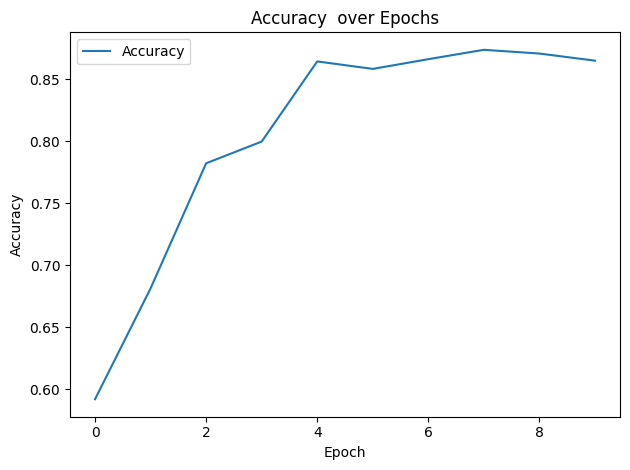

In [335]:
plt.plot(error.max_error, label = 'Accuracy')
#plt.axhline(y=avg, color='blue', linestyle='--', label='Average Error')
#plt.axhline(y=maximum, color='red', linestyle='-', label='Max Error')
plt.title('Accuracy  over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend()  
plt.show()

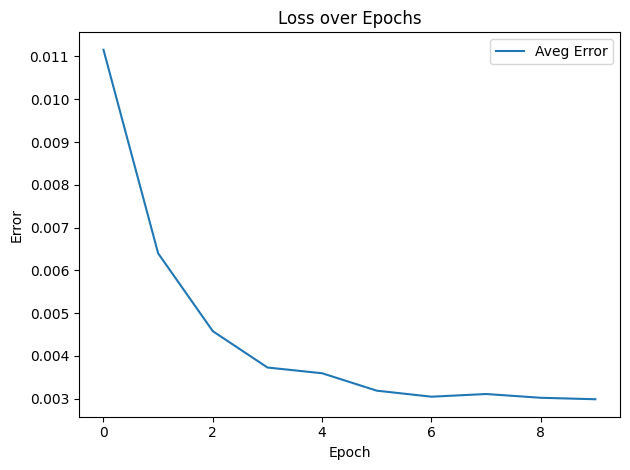

In [296]:
plt.plot(history.history['loss'], label = 'Aveg Error')
#plt.axhline(y=avg, color='blue', linestyle='--', label='Average Error')
#plt.axhline(y=maximum, color='red', linestyle='-', label='Max Error')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.tight_layout()
plt.legend()  
plt.show()

In [369]:
dataX = X[60:, 0]
print(testX.shape[0]+trainX.shape[0],dataX.shape)

4098 (4158,)


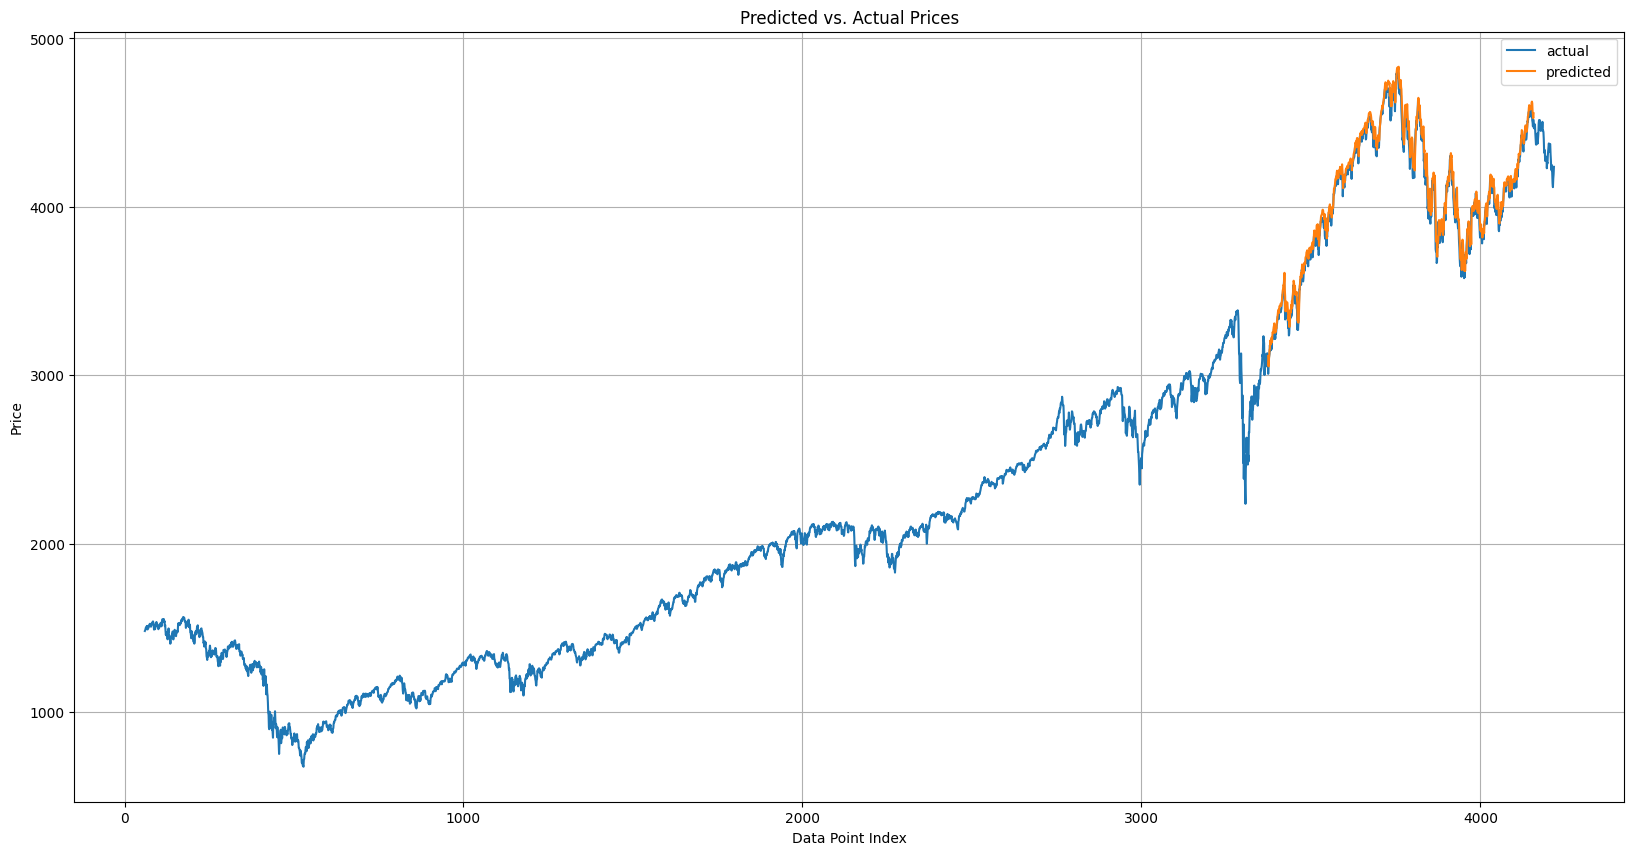

In [376]:
plt.figure(figsize=(20, 10))
plt.plot(range(60,X.shape[0]), dataX, label="actual")
plt.plot(range(train_size, train_size+test_size-60), yhat , label = "predicted")

# Set plot labels and legend
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Data Point Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()